# Damped Quantum Harmonic Oscillator Demo

In this notebook demo, we investigate the damped quantum harmonic oscillator and see how it can be implemented efficiently on a  quantum computer.


### Dependencies:

To run this notebook, you will need to install the following dependencies:

In [1]:
import qiskit
import numpy as np
import scipy
import matplotlib.pyplot as plt

You can do this by running `!pip3 install <dependency>` in an empty cell, where `<dependency>` is the name of each of the packages imported above. In addition, you will also need the `open_quantum_systems` Python source files for this project, which we import below:

In [2]:
import open_quantum_systems.qho

If this fails to import, be sure that the `open_quantum_systems` Python source files are located in the same directory as this notebook.

## Background

### The Lindblad Equation

The time-evolution of open quantum systems interacting with a large environment can be described by the Lindblad equation:

$$\dfrac{d\rho}{dt}(t) = -\frac{i}{\hbar}[H, \rho(t)] + \sum_{n} \gamma_n \left( L_n \rho(t)L_n^\dagger - \frac{1}{2}\lbrace L_n^\dagger L_n, \rho(t) \rbrace \right)$$

We can break down the components of this equation as follows:

* $\rho(t)$ is the density operator of the system at time $t$.
* $H$ is the system's Hamiltonian operator.
* The $L_n$ are the system's Lindblad operators, which describe the system's different modes of interaction with the environment.
* The $\gamma_n$ are scalar coupling parameters which describe the strength of each interaction $L_n$

Above, we also use the notation $[ \cdot , \cdot ]$ to denote the operator commutator, and $\{ \cdot , \cdot \}$ to denote the operator anticommutator. For any two operators $A$ and $B$, we compute the commutator and anticommutator as follows:

* $[ A, B ] = AB - BA$
* $\{ A, B \} = AB + BA$

Integrating the Lindblad equation for an arbitrary $H$ and set of $L_n$ and $\gamma_n$ to find the density matrix $\rho(t)$ at an arbitrary time $t$ usually requires numerical integration, since it only has a closed-form solution for certain systems. However, it can be shown that any such solution $\rho(t)$ can be written in the form:

$$\rho(t) = \sum_i K_i(t) \rho(0) K_i^\dagger(t)$$

where the $K_i(t)$ are the system's time-dependent Kraus operators. If the Kraus operators can be found in closed form, then the system's density $\rho(t)$ can be computed as a function of time without the need for numerical methods. 

### Why use a quantum computer?

Even if we know the Kraus operators $K_i(t)$ in closed form, it can still be quite costly to compute $\rho(t)$ on a classical computer, especially if $\rho(0)$ is an exponentially large quantum state. This is why using quantum computation can be advantageous, since a state of dimension $2^N$ requires only $N$ qubits to represent on a quantum computer. The ability of quantum computers to use exponentially smaller representations of a state $\rho(t)$ is a key advantage that we aim to exploit while simulating quantum mechanical systems.


### The Damped Quantum Harmonic Oscillator

The quantum harmonic oscillator has the Hamiltonian:

$$H = \frac{\hat{p}^2}{2m} + \frac{1}{2}m\omega^2\hat{x}^2$$

where:

* $\hat{p}$ is the momentum operator
* $\hat{x}$ are the position operator
* $m$ is the oscillator mass
* $\omega$ is the oscillator angular frequency

To simulate the Hamiltonian on a quantum computer, we must make the representation of the Hamiltonian discrete. We can do this by diagonalizing it and truncating the eigenstate representation to the lowest occupied modes. The easiest way to do this is by introducing the ladder operator $\hat{a}$:

$$\hat{a} = \sqrt{\frac{m\omega}{2\hbar}}\left(\hat{x} + \frac{i}{m\omega}\hat{p}\right)$$

Then we can express the diagonalized Hamiltonian as a function of $\hat{a}$ and its adjoint $\hat{a}$:

$$H = \hbar\omega\left(\frac{1}{2} + a^\dagger a\right)$$

In this diagonalized form, we can truncate $H$ to a diagonal matrix with entries $H_{nm}$ of the form:

$$H_{nm} = \hbar\omega \delta_{nm}\frac{n+1}{2} \ \qquad (\text{for } n = 0, 1, 2, ...)$$

To apply damping to the oscillator, we use $\hat{a}$ as the system's Lindblad operator. In the eigenbasis of $H$, $\hat{a}$ takes the form of a superdiagonal matrix:

$$L_1 = \hat{a} = \begin{pmatrix}
0 & \sqrt{1} & 0 & 0 & \dots & 0 \\
0 & 0        & \sqrt{2} & 0 & \dots & 0 \\
0 & 0 & 0 & \sqrt{3} & \dots & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & \dots & 0 \\
\end{pmatrix}$$

If we use an $N$-qubit approximation to the system, it means that the first $2^N$ modes of the oscillator are simulated, and the higher order modes are ignored.

### Kraus Series Representation of the Damped Quantum Harmonic Oscillator

Finding the Kraus operators in closed for an open quantum system can be quite difficult. In the case of the damped quantum harmonic oscillator, one can derive the following infinite series of Kraus operators:


$$\rho(t) = \sum_{m=0}^\infty K_m(t)\rho(0)K_m^\dagger(t)$$

where the Kraus operators $K_m(t)$ take the form:

$$K_{m}(t) = V(t)\sqrt{\frac{\gamma_1^m(t + \gamma_1g(t,\gamma_1)^m}{m!}}\hat{a}^m$$

Where $V(t)$ is given by:

$$\begin{aligned}
V(t) &= \exp\left(\frac{-it}{\hbar}H - \frac{\gamma_1}{2}a^\dagger a\right) \\
&= e^{-it\omega/2}\exp\left(\left[-it\omega - \frac{\gamma_1}{2}\right]a^\dagger a\right)
\end{aligned}$$

and $g(t,\gamma_1)$ is computed according to the function:

$$g(t, \alpha) = -\frac{e^{-\alpha t} + \alpha t - 1}{\alpha^2}$$

We can see that the representation is quite complex, but it essentially reduces to the product of three terms for each value of $m$. These terms (going from right to left) are:

* $\hat{a}^m$, the $m$-th power of the Lindblad operator $\hat{a}$, which is a matrix with nonzero entries only along the $m$-th superdiagonal.
* The scalar value $\sqrt{\frac{\gamma_1^m(t + \gamma_1g(t,\gamma_1)^m}{m!}}$
* $V(t)$, which is the exponential of a diagonal matrix (easy to compute).

Later on in this demo notebook we discuss the details of how each of these three terms in the Kraus operators are realized as quantum circuits. For now, it is important to make just one key observation about the Kraus operator series, and that is the following: If we are using a discretized $N$-qubit representation of $\hat{a}$ (which corresponds to a $2^N$ by $2^N$ matrix of the form above), then one can verify that taking $\hat{a}^m$ for $m \ge 2^N$ results in the zero matrix! This means that under an $N$-qubit discretization scheme, we only need to to include the nonzero Kraus operators in the series for $m < 2^N$. The cutoff value of $m$ that we select is called the _Kraus order_ of the approximation. Generally this cutoff value should correspond to the number of the highest initially occupied eigenstate of the quantum harmonic oscillator.

## Creating a Simulation

Now let's get our hands dirty and start simulating a damped oscillator system. To start, let's define the following parameters of the system:

* `HBAR`: The reduced Planck constant
* `OMEGA`: The oscillator angular frequency $\omega$
* `GAMMA`: The Linblad coupling parameter $\gamma_1$
* `MASS`: The oscillator mass

In [3]:
# Define system parameters 
HBAR = 1/(2*np.pi)
OMEGA = 2.0
GAMMA = 0.4
MASS = 1.0

Next, let's import the `QHOSimulation` object and create a simulation. We will use the parameters defined above, and use a 2-qubit approximation. Since we are only using a 2-qubit approximation, we only need to use a Kraus order of 3, since we are only modeling modes 0 through 3:

In [4]:
from open_quantum_systems.qho import QHOSimulation

sim = QHOSimulation(
    n_qubits=2,
    kraus_order=3,# <- Kraus order (set to the number of the highest occupied mode in the initial state)
    hbar=HBAR,
    omega=OMEGA,
    gamma=GAMMA
)

## Running a Classical Simulation:

To establish a baseline for the system trajectory, we will first simulate the trajectory of the system's density matrix by numerically integrating the Lindblad equation (via traditional "classical" computation).

We will initialize the system in the state:

$$\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{2} + \ket{3})$$

and simulate the trajectory for $t \in [0,10]$.

In [5]:
# The initial (pure) state of the system:
psi = np.array([ 0, 0, 1, 1.j])/np.sqrt(2)
t = np.linspace(0, 10.0, 1000)

In [6]:
# simulate the density matrix trajectory by solving the Lindblad equation:
rho_t = sim.simulate_classical_density_matrix_evolution(initial_state=psi,t=t)

Next, we get the discretized position and momentum operators for the system and plot the expectation value of position and momentum with respect to time:

In [7]:
# get position and momentum operators:
x_hat = sim.position_operator(m=MASS)
p_hat = sim.momentum_operator(m=MASS)

# compute the expectation values of the system's position and momentum:
position_t = np.trace(x_hat @ rho_t, axis1=-2, axis2=-1).real
momentum_t = np.trace(p_hat @ rho_t, axis1=-2, axis2=-1).real

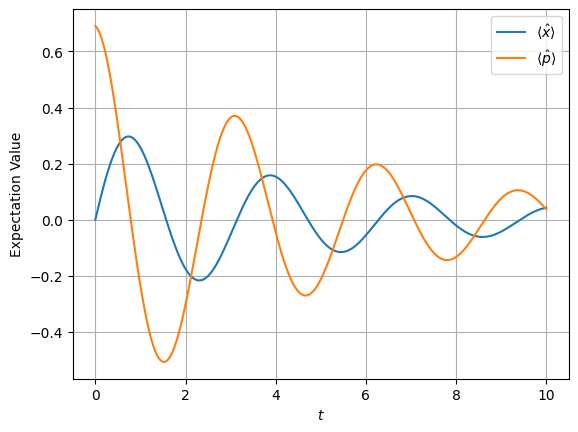

In [8]:
# plot trajectory of position (x) and momentum (p) expectation values:
plt.figure()
plt.plot(t, position_t, label=r'$\langle \hat{x} \rangle$')
plt.plot(t, momentum_t,label=r'$\langle \hat{p} \rangle$')
plt.xlabel(r'$t$')
plt.ylabel('Expectation Value')
plt.grid()
plt.legend()
plt.show()

The dynamics of the system (at least at the level of the expectation values) very closely resembles a damped classical Harmonic oscillator. However, we must remember that our wave function is in fact a probability distribution with respect to both position and momentum. We can plot this distribution as follows:

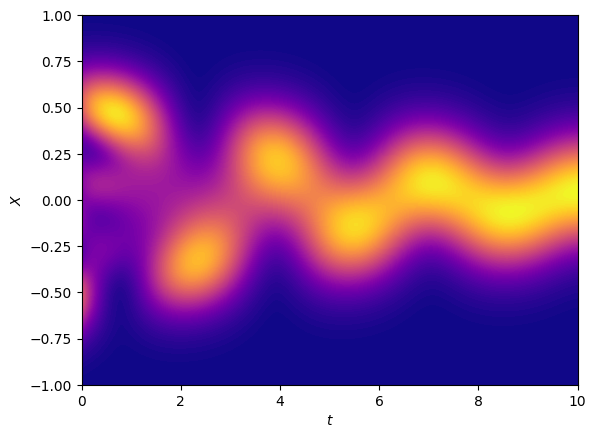

In [9]:
sim.plot_position_density_trajectory(t, rho_t, m=MASS, xlim=(-1,1))

## Running a Quantum Simulation:

Next, we will run a simulation on a (simulated) quantum computer using qiskit's Aer simulator. You can import the Aer backend as follows:

In [10]:
from qiskit_aer import Aer
aer_backend = Aer.get_backend('aer_simulator')

We can prepare and then simulate the evolution of our damped quantum harmonic oscillator from a pure state using the `simulate_pure_state_evolution` function. Fortunately, this function abstracts away many of the details of how the Kraus series is represented as a set of quantum circuits, but it is still quite configurable. We can learn more about this function by using Python's `help()` function:

In [11]:
help(sim.simulate_pure_state_evolution)

Help on method simulate_pure_state_evolution in module open_quantum_systems.qho:

simulate_pure_state_evolution(pure_state, t, backend, observable=None, shots=1024, masking=True, renormalize=True, transpile_options={}, run_options={}, result_options={}, primitive_kwargs={}) method of open_quantum_systems.qho.QHOSimulation instance
    Simulates the trajectory evolution of the system initialized in a pure state.
    
    Args:
        pure_state (np.ndarray): Initial pure state of the system (in the energy basis). Must be of length 2^(n_qubits).
        t (np.ndarray): Trajectory time values to sample during evolution.
        backend (qiskit.providers.Backend): Backend to use for the simulation.
        observable (np.ndarray, optional): If not None, the expectation value of this observable is returned
                                           for each t value in the trajectory. Defaults to None.
        shots (int, optional): Number of shots to use per quantum circuit. Defaults to 10

From the function's docstring, we see that it accepts an observable in matrix form and allows us to compute the expectation value of that observable over a trajectory. To track the expectation values of position and momentum, we need to pass in the `x_hat` and `y_hat` observables we created above and run one simulation for each of these:

In [12]:
t_sampling = np.linspace(0, 10.0, 20)
n_shots = 2048
position_quantum_t = sim.simulate_pure_state_evolution(
    pure_state=psi,
    t=t_sampling,
    backend=aer_backend,
    observable=x_hat,
    shots=n_shots,
)

In [13]:
momentum_quantum_t = sim.simulate_pure_state_evolution(
    pure_state=psi,
    t=t_sampling,
    backend=aer_backend,
    observable=p_hat,
    shots=n_shots,
)

Next, we plot the quantum computed trajectory on top of the classical trajectory of the system to verify that our (simulated) quantum computations were correct:

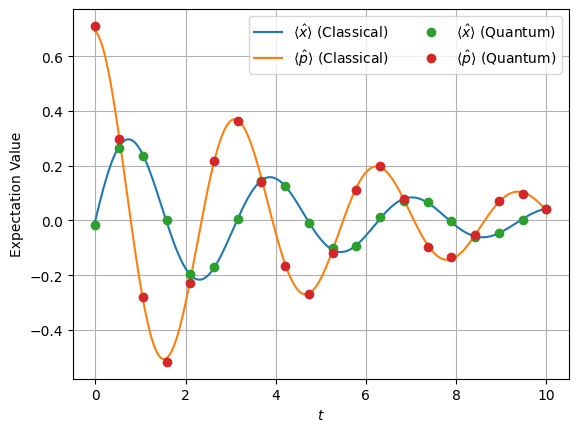

In [14]:
# plot trajectory of position (x) and momentum (p) expectation values:
plt.figure()
plt.plot(t, position_t, label=r'$\langle \hat{x} \rangle$ (Classical)')
plt.plot(t, momentum_t,label=r'$\langle \hat{p} \rangle$ (Classical)')
plt.plot(t_sampling, position_quantum_t, 'o', label=r'$\langle \hat{x} \rangle$ (Quantum)')
plt.plot(t_sampling, momentum_quantum_t, 'o', label=r'$\langle \hat{p} \rangle$ (Quantum)')
plt.xlabel(r'$t$')
plt.ylabel('Expectation Value')
plt.grid()
plt.legend(ncol=2)
plt.show()

Great! it looks like our results align well with the classical trajectory. Note that if the results aren't as accurate as you would like, you can always increase the number of "shots" (i.e. the number of times we measure the output of each quantum circuit) to obtain results with less error. It is important to note that our simulation is that of an ideal quantum computation. Real quantum computers are very noisy, and noise can become problematic for simulations requiring many qubits.

In addition to measuring expectation values, we can also simulate the approximate trajectory of the entire density matrix, though on a quantum computer this can be much more costly than simply computing the expectation value of an observable. We can do this with the `simulate_pure_state_density_evolution` function:

In [15]:
help(sim.simulate_pure_state_density_evolution)

Help on method simulate_pure_state_density_evolution in module open_quantum_systems.qho:

simulate_pure_state_density_evolution(pure_state, t, backend, shots=1024, masking=True, renormalize=True, positive_definite=True, transpile_options={}, run_options={}, result_options={}, primitive_kwargs={}) method of open_quantum_systems.qho.QHOSimulation instance
    Simulates the trajectory evolution of the system initialized in a pure state.
    
    Args:
        pure_state (np.ndarray): Initial pure state of the system (in the energy basis). Must be of length 2^(n_qubits).
        t (np.ndarray): Trajectory time values to sample during evolution.
        backend (qiskit.providers.Backend): Backend to use for the simulation.
        shots (int, optional): Number of shots to use per quantum circuit. Defaults to 1024.
        masking (bool, optional): If True, suppresses "impossible" measurement outcomes for 
                                  each Kraus operator. Defaults to True.
        renor

Next, we simulate the full density matrix of the system and plot the resulting distribution of $\hat{x}$ with respect to time:

In [16]:
rho_quantum_t = sim.simulate_pure_state_density_evolution(
    pure_state=psi,
    t=t_sampling,
    backend=aer_backend,
    shots=n_shots,
)

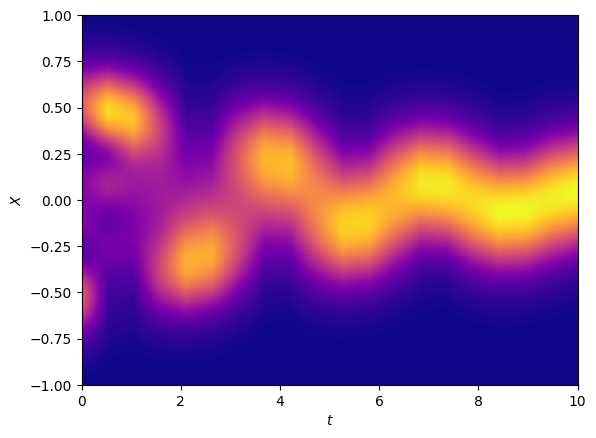

In [17]:
sim.plot_position_density_trajectory(t_sampling, rho_quantum_t, m=MASS, xlim=(-1,1))

We can see that the position density obtained from our quantum computation is almost identical to our classical simulation!

## How does it work?

Previously, we showed that the closed form of the damped quantum harmonic oscillator Kraus operators can be broken down to three terms (going from right to left):

* $\hat{a}^m$, the $m$-th power of the Lindblad operator $\hat{a}$, which is a matrix with nonzero entries only along the $m$-th superdiagonal.
* The scalar value $\sqrt{\frac{\gamma_1^m(t + \gamma_1g(t,\gamma_1)^m}{m!}}$
* $V(t)$, which is the exponential of a diagonal matrix (easy to compute).

In this section, we will explore in greater detail how these three terms in the Kraus operator can be realized on a quantum computer. First, let's examing the form of $V(t)$ for the quantum Harmonic oscillator. Since $H$ and $\hat{a}^\dagger \hat{a}$ commute, we can write $V(t)$ as the product of two diagonal matrices:

$$V(t) = W(t)\Lambda(t)$$

where $W(t) = \exp\left(-\frac{it}{\hbar}H\right)$ is the unitary evolution of the diagonalized Hamiltonian and $\Lambda(t) = \exp\left(-\frac{\gamma_1}{2}\hat{a}^\dagger \hat{a}\right)$ is the non-unitary evolution of the system. If we separate out $W(t)$ from the rest of the Kraus operator, we obtain the following:

$$K_m(t) = W(t)\left[ \Lambda(t)\sqrt{\frac{\gamma_1^m(t + \gamma_1g(t,\gamma_1)^m}{m!}} \hat{a}^m \right]$$

where $W(t)$ consists of the (diagonal) unitary component of the dynamics, and the remaining terms in brackets are the nonunitary terms that correspond to the oscillator interacting with its environment.

To see how these operations correspond to quantum circuits, let's take a look at the circuits representing the kraus operators $K_{m}$ in our `QHOSimulation` object. We can access the cutoff order of the Kraus series $M$ and the $M+1$ circuits used to approximate the Kraus operators $K_0(t), K_1(t), ..., K_{M-1}(t)$ as follows:

In [18]:
print('Kraus order (M) is:', sim.kraus_order)

sim.kraus_circuits

Kraus order (M) is: 3


Let's start by examining the simplest term in the series, the $K_0$ Kraus operator, which has the form:

$$K_0(t) = W(t)\Lambda(t)$$

(Since $m = 0$, the remaining terms vanish.)

Reading from right to left, we see that the diagonal decoherence operator $\Lambda(t)$ is applied first, followed by the unitary operator $W(t) = \exp(-itH/\hbar)$. If we draw the first circuit, we see that these two terms are applied first in the circuit:

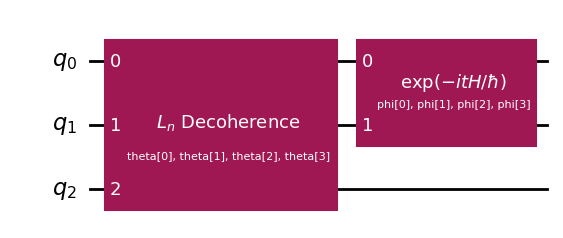

In [19]:
sim.kraus_circuits[0].draw('mpl')

Since our simulation is $N$ qubits in size, we use the first $N$ qubits to represent the state of the system and the $N+1$th qubit as an ancilla qubit, which is necessary to apply non-unitary dynamics to the first two qubits. That is why the $L_n$ decoherence circuit (i.e. $\Lambda(t)$) requires the ancilla qubit, whereas the $\exp(-itH/\hbar)$ circuit (i.e. $W(t)$) requires no ancillas.

We also see that there are a vector of parameters assiociated with the $\Lambda(t)$ and $W(t)$ circuits, namely $\theta_0, ..., \theta_{2^{N}-1}$ and $\phi_{0}, ..., \phi_{2^N-1}$. These parameters are necessary to encode the diagonal form of $\Lambda(t)$ and $W(t)$ respectively.

If we decompose the blocks in the $K_0$ circuit above, we see that $\Lambda(t)$ is implemented through a sequence of $2^{N}$ controlled $R_y$ operations on the ancillary qubit (with parameters $\theta_i$) and that $W(t)$ is implemented through a sequence of controlled phase gates on the system qubits (with parameters $\phi_i$):

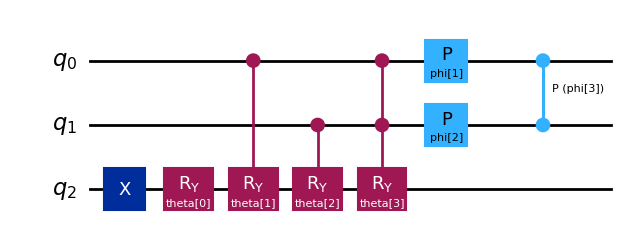

In [20]:
sim.kraus_circuits[0].decompose().draw('mpl')

By calculating the parameters $\theta_i$ and $\phi_i$ that correspond to a particular time evolution period $t$, we can simulate the time evolution of the system. In this notebook, we will not go into details about how these parameters are computed, but we will say that they can be computed efficiently on a classical computer $O(2^N\log(2^N))$ time, where $2^N$ is the dimension of the system we are simulating. For each time $t$ in the simulated trajectory, a classical computer is used to compute the $\theta_i$ and $\phi_i$ parameters, which are then loaded into the quantum computer for circuit execution.

Next, let's take a look at the decomposed $K_{M}(t)$ circuit and see how it compares with that of the $K_0(t)$ circuit:

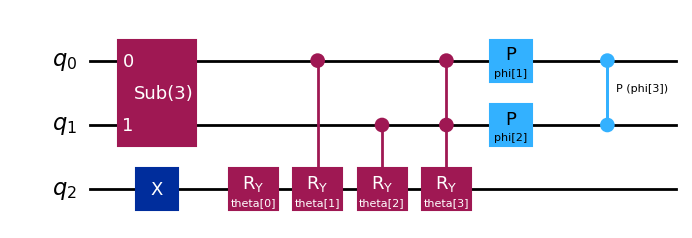

In [21]:
sim.kraus_circuits[-1].decompose().draw('mpl')

We see here that the only key difference between this circuit and the $K_0(t)$ circuit is the addition of a `Sub(m)` gate at the beginning of the circuit. This gate performs a quantum subtraction operation by $m$. This subtraction operation is necessary to realizing the powers of $\hat{a}^m$ that appear in the formula for these Kraus operations. In particular, we observe that the matrix form of $\hat{a}^m$ can be written as a "shift" matrix times a diagonal nonunitary matrix $\Lambda_{a_m}$:

$$\hat{a}^m = \Lambda_{a^m} \left(\sum_{i=0}^{2^N-1} \ket{n-m}\bra{n}\right) = \Lambda_{a^m}(\text{Sub}_{m})$$

Since our circuit can already handle a single diagonal non-operator, $\Lambda$, we can combine the diagonal non-unitary part of $\Lambda_{a^m}$ and the scalar term $\sqrt{\frac{\gamma_1^m(t + \gamma_1g(t,\gamma_1)^m}{m!}}$ into a single nonunitary diagonal operator $\Lambda_m'(t)$, which has the form:

$$\Lambda_m'(t) = \sqrt{\frac{\gamma_1^m(t + \gamma_1g(t,\gamma_1)^m}{m!}}\Lambda(t)\Lambda_{a^m}$$

We can then re-write $K_m(t)$ in a simplified form as a product of three operators:


$$K_m(t) = W(t)\Lambda_m'(t)(\text{Sub}_m)$$

This shows why the $\text{Sub}_m$ gate must be added to the circuit for $m > 0$. We can see what the $\text{Sub}_m$ gate looks like by constructing one and decomposing it. For example, let's create a $\text{Sub}_3$ gate acting on $4$ qubits:

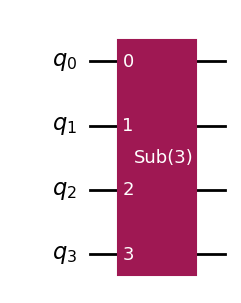

In [22]:
from open_quantum_systems.qho import make_sub_n_gate
from qiskit import QuantumCircuit

# Build a subtraction gate for n_qubits that maps |x> to |x-sub>:
n_qubits = 4
sub = 3

# comstruct gate:
sub_gate = make_sub_n_gate(n_qubits=n_qubits, n=sub)

# view gate as quantum circuit
qc = QuantumCircuit(n_qubits)
qc.append(sub_gate, list(range(n_qubits)))
qc.draw('mpl')

The $\text{Sub}_3$ gate is essentially equivelnt to a performing a classical subtraction logic on 3 bits. This means that it can be constructed from only controlled-NOT gates:

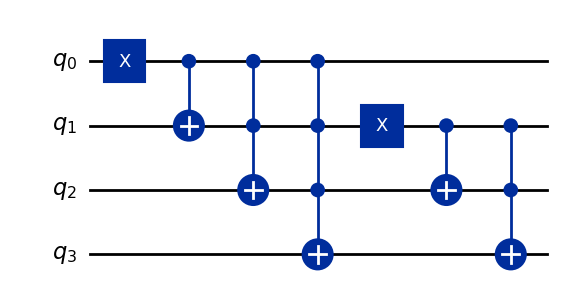

In [23]:
# decompose gate into controlled X gates:
qc.decompose().draw('mpl')